# COGS 108 - Final Project 

# Overview

The project studied the relationship between park accessibility and the public perception of those parks. Through a combination of population proximity data from the California Department of Health and Yelp ratings for parks in San Diego, we concluded that an increased availability of parks does not imply improved perception of parks among Yelp users. This conclusion was extended, though conservatively, to the population of San Diego.

# Name & GitHub ID

- Name: Austin Du
- GitHub Username: austinrdu5

# Research Question

Do regions (designated CDPs) with greater access to parks produce higher (Yelp) ratings for their parks?

## Background and Prior Work

Many believe parks to be beneficial to the human experience in multifaceted ways, from relieving anxiety to interacting more with community. Given these benefits, one would assume that parks should be an integral part in many communities. However, at least at the city level, researchers have long confirmed that park access is largely unequal [1]. Many socio-economic factors were found to be correlated to this discrepancy, including population density, job density, and poverty rate. [2]. As a result, the access to parks remains a contentious issue, offering some potentially unique solutions to city-specific issues.

While the above-mentioned studies reflect overall benefits of parks within a community, many proposed municipal changes often face resistance from city residents [3]. As a result, the interesting question arises of whether public perception of parks matches the resident satisfation that the prior research alludes to. Insofar as a Google search, this question has not been explicitly explored before.

References (include links):
- 1) https://ij-healthgeographics.biomedcentral.com/articles/10.1186/1476-072X-8-34
- 2) https://www.brookings.edu/blog/the-avenue/2019/08/21/parks-make-great-places-but-not-enough-americans-can-reach-them/
- 3) https://www.post-gazette.com/local/city/2019/10/31/Parks-referendum-to-ask-city-residents-to-raise-their-taxes/stories/201910310164

# Hypothesis


Regions with greater access to parks do not give their parks higher ratings. Despite the greater presence and accessibility of the parks, many residents would be either indifferent or unaware of the park's positive impact on their community.

# Dataset(s)

- Dataset Name: San Diego Parks Yelp Data
- Link to the dataset: https://www.yelp.com/ (provided by Prof Ellis)
- Number of observations: 834

List of all parks within San Diego county containing data about ratings, reviews, and location.

- Dataset Name: CA Access to Parks Data
- Link to the dataset: https://data.ca.gov/dataset/park-beach-open-space-or-coastline-access
- Number of observations: 543187

Data for proportion of population within 1/2 mile to a park, beach, open space, or coastline. Rows are divided into categories pertaining to demographic and granularity of the geographic region (city, county, state, etc.).

From the first dataset, we will extract ratings, corresponding to the park zip codes. Those zip codes will be used to relate park ratings to a general region, for which we will have the park-access metric from the second dataset.

# Setup

In [278]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import requests
import time
import sklearn
from sklearn.linear_model import LinearRegression
import scipy.stats as stat

In [2]:
yelp_raw = pd.read_csv('../data/yelp_SD_parks.csv', 
                       usecols = ['address', 'rating', 'review_count'], 
                      )

parks_raw = pd.read_excel('../data/hci_accesstoparks_469_ca_re_co_cd_pl_ct-7-3-2017-ada.xlsx',
                          skiprows = np.arange(1,460000),
                          usecols = ['race_eth_name', 'geotype', 'geoname', 'county_name', 'strata_one_name', 'numerator',
                                 'denominator', 'estimate', 'll_95ci', 'ul_95ci', 'se', 'rse'],
                         )

In [22]:
yelp_raw.head()

,address,rating,review_count
0,"1549 El Prado San Diego, CA 92101",5.0,2105
1,"7960 Civita Blvd San Diego, CA 92108",4.5,46
2,"1600 Pacific Hwy San Diego, CA 92101",4.5,242
3,"Adams Ave And Florida St San Diego, CA 92116",4.5,102
4,"413 1st St Coronado, CA 92118",5.0,42


In [4]:
parks_raw.head()

,race_eth_name,geotype,geoname,county_name,strata_one_name,numerator,denominator,estimate,ll_95ci,ul_95ci,se,rse
0,NHOPI,PL,Adin CDP,Modoc,State,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,NHOPI,PL,Adin CDP,Modoc,Other,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,NHOPI,PL,Adin CDP,Modoc,Total,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,White,PL,Adin CDP,Modoc,City,0.0,224.0,0.0,0.0,0.0,0.0,NaN
4,White,PL,Adin CDP,Modoc,County,0.0,224.0,0.0,0.0,0.0,0.0,NaN


# Data Cleaning

In the Yelp data, we used the addresses of the parks to extract only the zip codes. 5 zip codes were missing. Those that were real parks had their zip codes manually inputted after a quick Google Search. Those that were not parks were omitted from the dataframe. We then take the average park rating in a zip code, weighted by the number of reviews. 

In the park accessibility data, we first filtered for only regions in San Diego. We then Considered only the rows of combined individuals. That is, we look only at the entire geographical region (instead of finer subdivisions) and only at total population (instead of distinguishing by race/ethnicity). The first choice was justified because a cursory examination of the data revealed that any smaller geographical subdivisions often produced too few data points to be reliable (see next paragraph). The second choice was less justified, but shapes this project into a more comprehensive analysis. Future reports, grouped by race/ethnicity should be conducted. Lastly, we limited our estimates to those whose Relative Standard Errors were smaller than 30%, based on a recommendation within the dataset.

To combine the data, we had to assign the zip codes in the first dataframe to the region names in the second. This was done by scraping Wikipedia pages for the regions. Once this was done, and complications (repeated/missing zip codes) were resolved, we joined the two dataframes and proceed to analysis.

### Yelp Dataset

In [5]:
# get zip codes 
yelp = yelp_raw.assign(zip_code = yelp_raw.address.str.split().str[-1]).drop('address', 1)

# edge cases that were missing zip codes
yelp.iloc[226, 2] = '92114'    # for Officer Christopher Wilson Memorial Park
yelp.iloc[747, 2] = '92129'    # for Miner's Ridge Loop Trail
yelp.drop(314, inplace = True) # for City of Otay Mesa (not a park)
yelp.drop(312, inplace = True) # for Arco del Milenio (not in San Diego)
yelp.drop(556, inplace = True) # for Parque Teniente Guerrero (not in San Diego)

### Park-access Dataset

In [6]:
## Filter for the following conditions:

# parks in San Diego County
in_sd = parks_raw.county_name == 'San Diego'
# considers entire geographical region
is_total_region = parks_raw.strata_one_name == 'Total'
# considers only total demographic
is_total_demo = parks_raw.race_eth_name == 'Total'
# has RSE < 30 (recommended by National Standard for Health Statistics)
low_rse = parks_raw.rse < 30

# apply filters and remove unnecessary columns
parks = parks_raw.loc[in_sd & is_total_region & is_total_demo] \
                 .drop(['race_eth_name', 'geotype', 'county_name', 'strata_one_name'], 1)

# edit the names of the regions
parks = parks.assign(geoname = parks.geoname.str[:-4].str.rstrip(' '))
parks.head()

,geoname,numerator,denominator,estimate,ll_95ci,ul_95ci,se,rse
1106,Alpine,6576.0,14236.0,46.192751,45.373778,47.011723,0.417843,0.904564
7154,Bonita,12419.0,12538.0,99.050885,98.881166,99.220604,0.086591,9.123379
7262,Bonsall,1609.0,3982.0,40.406831,38.882669,41.930993,0.777634,1.924510
7532,Borrego Springs,1957.0,3429.0,57.072033,55.415293,58.728772,0.845275,1.969055
7586,Bostonia,2726.0,15379.0,17.725470,17.121905,18.329034,0.307941,1.737280


## Wikipedia Parsing

Parse through the Wikipedia pages of each region and find where the zip codes are stored. Place all strings in the *zips* dataframe. Clean strings by converting into list of available zip codes.

In [7]:
base_url = 'https://en.wikipedia.org/wiki/{},_California'

# prepare the names of all regions to be parsed
place_names = parks.geoname

# dataframe to store resulting zip codes
zips_raw = pd.DataFrame(columns = ['zip_codes'], index = place_names)

In [8]:
for place in place_names:
    
    # format place names
    place_url = place.replace(' ','_')
    if place_url == 'Spring_Valley':                       # there is a disambiguation page for Spring Valley
        place_url = 'Spring_Valley,_San_Diego_County'
        
    test_url = base_url.format(place_url)
    soup = bs(requests.get(test_url).text)
    big_table = soup.find('div', id = 'content').find('div', id = 'bodyContent') \
                    .find('div', id = 'mw-content-text') \
                    .find('div', class_ = 'mw-parser-output') \
                    .find('table', class_ = 'infobox geography vcard') \
                    .find_all('tr', class_ = 'mergedtoprow')

    zc = ''
    for tr in big_table:
        if tr.find('td', class_ = 'adr') is None:
            continue
        zc += tr.find('td').find('div').text

    zips_raw.loc[place, 'zip_codes'] = zc
    time.sleep(.5)


### Further Cleaning

Some zip codes are given as ranges. Change this to a list of strings.

In [9]:
def clean_zips(string):
    # list of zip codes
    zips = string.split(', ')
    
    new_zs = []
    bad_zs = []
    for z in zips:
        if '–' in z:
            z_range = list(map(int, z.split('–')))
            new_zs += list(map(str, range(z_range[0], z_range[1]+1)))
            bad_zs += [z]
        if '-' in z:
            z_range = list(map(int, z.split('-')))
            new_zs += list(map(str, range(z_range[0], z_range[1]+1)))
            bad_zs += [z]

    for z in bad_zs:
        zips.remove(z)
        
    return zips + new_zs

In [10]:
zips = zips_raw.assign(zip_codes = zips_raw.zip_codes.apply(clean_zips))
zips.tail()

,zip_codes
geoname,
Solana Beach,[92075]
Spring Valley,"[91976, 91977, 91978, 91979]"
Valley Center,[92082]
Vista,"[92081, 92083, 92084, 92085]"
Winter Gardens,[92040]


## Joining Data

Combine our two original dataframes using the *zips* dataframe.

In [11]:
# average rating for each region, weighted by number of reviews
g = yelp.groupby('zip_code')
yelp_weighted = g.apply(lambda x: pd.Series([(x.rating*x.review_count/x.review_count.sum()).sum(), x.review_count.sum()],
                                            index = ['rating_weighted', 'total_count']))

yelp_weighted.head()

,rating_weighted,total_count
zip_code,,
90069,4.5,53.0
90670,4.0,4.0
90717,3.5,17.0
90815,3.5,9.0
91010,4.5,19.0


In [12]:
# create new dataframe, with one row for each entry
temp = zips.reset_index().to_dict('records')
new_list = []
for dct in temp:
    for z in dct['zip_codes']:
        if len(z) <= 0:
            continue
        new_list.append([dct['geoname'], z])
df = pd.DataFrame(new_list, columns = ['geoname', 'zip_code'])
joined = df.join(yelp_weighted, on = 'zip_code', how = 'outer')

in_sd = joined.zip_code.apply(lambda x: int(x) >= 91901 and int(x) <= 92199)
joined = joined.loc[in_sd].reset_index(drop = True)

joined.iloc[182, 0] = 'Escondido'   # searched zip code in Google
joined.drop(index = [183,184,185,186], inplace = True)

In [15]:
g = joined.groupby('geoname')
all_weighted = g.apply(lambda x: pd.Series(
        [(x.rating_weighted*x.total_count/x.total_count.sum()).sum(), x.total_count.sum()],
                                            index = ['rating_weighted', 'total_count']))

final = parks.join(all_weighted, on= 'geoname', how = 'inner')
final = final[final.total_count > 0]
final.shape

(38, 10)

We finish with 38 census-designated places that have parks with at least one Yelp review.

# Data Analysis & Results

Plot the scatterplot between the park-access metric and the average rating.

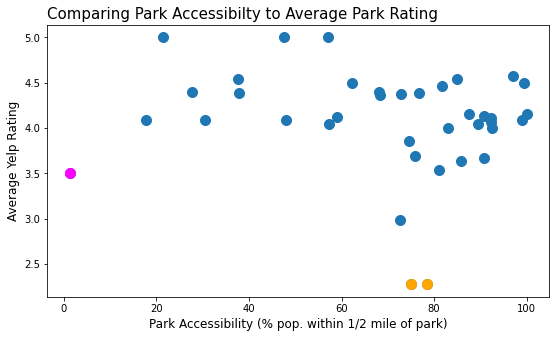

In [312]:
plt.figure(figsize = (9,5))
plt.title('Comparing Park Accessibilty to Average Park Rating', size = 15, loc = 'left')
plt.xlabel('Park Accessibility (% pop. within 1/2 mile of park)', size = 12)
plt.ylabel('Average Yelp Rating', size = 12)

x = final.estimate
y = final.rating_weighted
plt.scatter(x,y, s = 100)

outlier1 = final.query('estimate < 10')
plt.scatter(outlier1.estimate, outlier1.rating_weighted, color = 'magenta', s = 100)
outlier2 = final.query('rating_weighted < 2.5')
plt.scatter(outlier2.estimate, outlier2.rating_weighted, color = 'orange', s = 100)

plt.show()

Superficially, we see a roughly horizontal distribution of points, in line with our hypothesis. We first examine outliers. There is one point, labeled pink, with an extremely low park accessibility but with a moderate average rating. There are also two regions, labeled orange, with particularly low ratings, despite high park-accessibity.

The first outlier corresponds to Hidden Meadows, CA. A quick Google search show that it is a town located deep within the Merriam Mountains, potentially explaining its low park-accessibility.

The second set of outliers comes from Lamar Park in Spring Valley. It's zip code actually places it in 2 census-divided regions, which is why the data point appears twice in the scatterplot. We note the duplicate points are not redundant, but rather represent two communities with similar access to the same park.

Neither set of outliers seems to be a mistaken entry, so we leave the data as is and continue with the analysis.

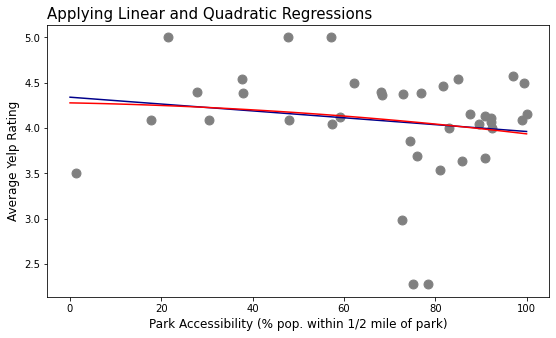

R^2 for linear regression: 0.0262
R^2 for quadratic regression: 0.027


In [313]:
plt.figure(figsize = (9,5))
plt.title('Applying Linear and Quadratic Regressions', size = 15, loc = 'left')
plt.xlabel('Park Accessibility (% pop. within 1/2 mile of park)', size = 12)
plt.ylabel('Average Yelp Rating', size = 12)

x = np.linspace(0,100)
X = final.estimate
Y = final.rating_weighted
plt.scatter(X, Y, color = 'gray', s = 80)

b_1, b_0, r, p, se = stat.linregress(X,Y)
plt.plot(x, b_0 + b_1* x, 'darkblue')
r_linear = sklearn.metrics.r2_score(Y, b_0 + b_1* X)

p = np.polyfit(X, Y, 2)
plt.plot(x, p[0]* x**2 + p[1]*x + p[2], color = 'red')
r_quad = sklearn.metrics.r2_score(Y, p[0]* X**2 + p[1]*X + p[2])

plt.show()
print('R^2 for linear regression: {}'.format(np.round(r_linear, 4)))
print('R^2 for quadratic regression: {}'.format(np.round(r_quad, 4)))

Neither regression model is very promising, but that could be due to the small number of samples, a result of uncommmon parks having no reviews in Yelp.

We continue analysis on the relation ship between park accessibility and the number of Yelp Reviews, by region.

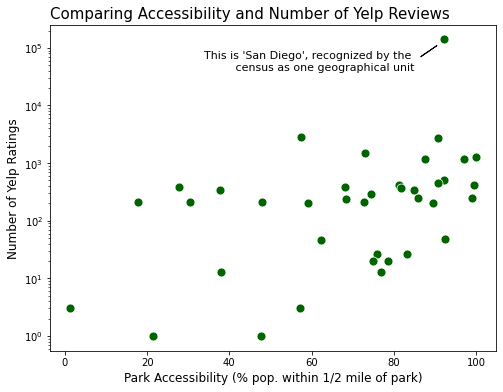

In [321]:
plt.figure(figsize = (8,6))
plt.title('Comparing Accessibility and Number of Yelp Reviews', size = 15, loc = 'left')

p = sns.scatterplot(final['estimate'], final['total_count'], color = 'darkgreen', s = 80)
plt.text(85, 40898, "This is 'San Diego', recognized by the \n census as one geographical unit", 
         horizontalalignment='right', size= 11, color='black', weight='normal')
plt.arrow(86.5,  70000, 4, 40000)

plt.xlabel('Park Accessibility (% pop. within 1/2 mile of park)', size = 12)
plt.ylabel('Number of Yelp Ratings', size = 12)
p.set(yscale= 'log')
plt.show()

The above scatterplot is on a log-scale, because the number of Yelp ratings is largely based on population, which differs greatly throughout San Diego county. Additionally, the provided census data classifies the populous 'San Diego' area with its 36 zip codes as one region, accumulating much of the insightful population information within one data point, and placing it over an order of magnitude above the other regions. An improved and likely more successful analysis would be possible if the data were further subdivided. Unfortunately, the given data does not offer such granularity.

# Ethics & Privacy

Since most of the parks listed are likely government property, this project saw little use of any personally identifying information. The Yelp dataset did include phone numbers for the listings, but those were likely public phone numbers as well. The usually notable privacy concern is the heavy usage of zip codes in our data. Typically, one would remove the last two digits of the zip code to avoid any risks of identification. This procedure was initially considered, but ultimately rejected since zip codes were representative of public areas rather than personal households. Also, as our data analysis shows, our final dataset left much to be desired in granularity. Clustering data points further would only exacerbate this problem.

The dataset about park accessibility seems to be free of bias. It originates from the California department of public health and contains accounts for potential discrepancies in different racial/ethnic groups. However, any observations about those sensitivities are absent in this project, since our data was aggregated before our analysis. Therefore, we run the risk of over-generalizing and maintain that the results of this project represent only a blanket observation within the county of San Diego. On the other hand, the Yelp dataset is collected from a much less objective and organized source. Online reviews could disproportionately represent the concerns of individuals with ready access to technology, minimizing lower-income, even homeless populations for whom parks are equally impactful. Thus, any conclusions drawn from this paper necessitate further representative research.

# Conclusion & Discussion

This project examined the relationship between park-accessibility and public perception of those parks within regions of San Diego County. To do this, data was gathered from the California Department of Public Health, that estimated the proportion of the population within 1/2 a mile to a public park, as well as Yelp reviews of parks across San Diego. Using the parks' zip codes and the zip codes of each census designated place scraped from Wikipedia, we aggregated park ratings for each region and compared it to the region's park accessibility. Both linear and quadratic regressions were conducted, but neither yielded a large enough R^2 value to refute the hypothesis. We conclude that higher accessibility does not imply a greater perception of parks in San Diego. 

This result, however, is limited to the sentiment of Yelp reviews and their representation of the San Diego population. The conclusions are also limited by the relatively low sample size, likely due to the scarcity of Yelp reviews in less populous areas of San Diego. Even with 58 districts to begin with, many either lacked parks or lacked park ratings, and were omitted from our analysis. Accounting for the limitations, the results indeed confirmed the hypothesis that park ratings not dependent on park accessibility. This observation could imply that the residents of San Diego are indifferent to their cities' public parks, despite their numerous demonstrated benefits. 
